## Imports

In [2]:
import torch
import torch.nn as nn
import scipy.stats as stats
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import optim
import matplotlib.pyplot as plt

In [3]:
from icnnet import ICNNet
from mydataset import MyDataset
import toy_data_dataloader_gaussian

from gaussian_transport import compute_A, compute_w, guassian_transport

In [4]:
%load_ext autoreload
%autoreload 2

## Toy data


In [5]:
dataloader, locs, scales = toy_data_dataloader_gaussian.get_dataloader(N = 500, batch_size = 100, r = 250)

In [6]:
# cur_X = dataloader.dataset.X
# dataloader.dataset.X = dataloader.dataset.Y
# dataloader.dataset.Y = cur_X
# C = dataloader.dataset.C

In [7]:
cov1 = np.eye(2)
cov2 = np.eye(2)
m1 = np.zeros(2)
m2 = np.ones(2)

A = compute_A(cov1, cov2)
w = compute_w(m1, m2, A)

In [8]:
x = list()
c = list()
y_transport = list()
for x_batch, c_batch, y_batch in dataloader:
    x.append(x_batch)
    c.append(c_batch)
    results = []
    for i in range(x_batch.shape[0]):
        for j in range(x_batch.shape[1]):
            result = guassian_transport(x_batch[i, j], A, w)
            results.append(result)
    y_transport.append(torch.stack(results).reshape((x_batch.shape[0], x_batch.shape[1],1)))

X = torch.cat(x, dim = 0)
C = torch.cat(c, dim = 0)
Y = torch.cat(y_transport, dim = 0).float()

gaussian_dataset = MyDataset(X, C, Y)
gaussian_dataloader = DataLoader(gaussian_dataset, batch_size=100, shuffle=True)

c:\Users\dmgtr\OneDrive - Ecole Polytechnique\3A\P2\MAP588 - EA CondOT\CondOT\gaussian_transport.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u)


## __Training__

### PICNN training

In [16]:
epochs = 100

# Initialize the model
input_size = 2
output_size = 1

model = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    for x_batch, c_batch, y_batch in gaussian_dataloader:
        x_batch.requires_grad_(True)
        c_batch.requires_grad_(True)

        optimizer.zero_grad() # Zero the gradients
        
        output = model(x_batch, c_batch)  # Assuming context c is same as input x

        loss = criterion(output, y_batch) # Compute the loss
        loss.backward() # Backward pass

        optimizer.step() # Update the parameters
        for layers_k in model.layers_z:
            for param in layers_k.parameters():
                param.data.clamp_min_(0)

    # for name, parameter in model.named_parameters():
    #     if parameter.requires_grad and parameter.grad is not None:
    #         grad_norm = parameter.grad.norm().item()
    #         print(f"Gradient norm for {name}: {grad_norm}")
    
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")

Epoch 1/150 Loss: 4.51391077041626
Epoch 2/150 Loss: 3.000880241394043
Epoch 3/150 Loss: 2.066343069076538
Epoch 4/150 Loss: 2.2694530487060547
Epoch 5/150 Loss: 1.9363070726394653
Epoch 6/150 Loss: 1.894675612449646
Epoch 7/150 Loss: 1.9636106491088867
Epoch 8/150 Loss: 1.8544113636016846
Epoch 9/150 Loss: 1.819947600364685
Epoch 10/150 Loss: 1.7526999711990356
Epoch 11/150 Loss: 1.704208493232727
Epoch 12/150 Loss: 1.6051980257034302
Epoch 13/150 Loss: 1.5429450273513794
Epoch 14/150 Loss: 1.458945631980896
Epoch 15/150 Loss: 1.318638563156128
Epoch 16/150 Loss: 1.1600885391235352
Epoch 17/150 Loss: 1.0219417810440063
Epoch 18/150 Loss: 0.9168437719345093
Epoch 19/150 Loss: 0.7801970839500427
Epoch 20/150 Loss: 0.7274410128593445
Epoch 21/150 Loss: 0.6427323818206787
Epoch 22/150 Loss: 0.6283604502677917
Epoch 23/150 Loss: 0.5985327959060669
Epoch 24/150 Loss: 0.5716137290000916
Epoch 25/150 Loss: 0.543112576007843
Epoch 26/150 Loss: 0.5229901671409607
Epoch 27/150 Loss: 0.4669593274

KeyboardInterrupt: 

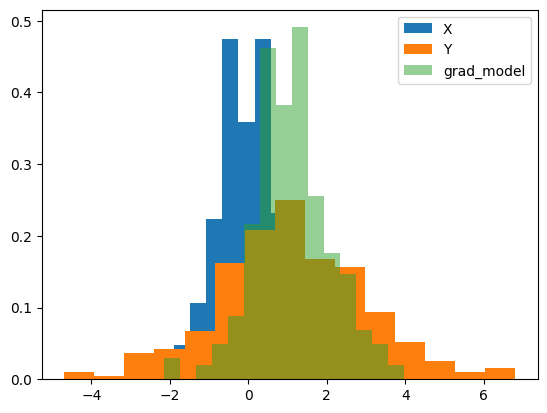

In [21]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C

#Calcul de la dérivée du PICNN

test = 20
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
#c_i.requires_grad_(True)    

output_model = model(x_i, c_i)

grad_model = torch.autograd.grad(outputs=output_model, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model[:, 0].detach().numpy(),  bins=15, label = 'grad_model', density = True, alpha = 0.5)
# plt.hist(X_pred,  bins=15, label = 'X_pred', density = True, alpha = 0.5)

plt.legend()

plt.show()

### PICNN training

## __Makkuva__

In [25]:
# Initialize the model
input_size = 2
output_size = 1

ICNNf = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])
ICNNg = ICNNet(input_size = input_size, layer_sizes = [input_size, 64, 64, 64,output_size], context_layer_sizes=[input_size, 64, 64, 64,output_size])

# Get the state dictionary from the trained model
state_dict = model.state_dict()

# Load the state dictionary into ICNNf and ICNNg
ICNNf.load_state_dict(state_dict)
ICNNg.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
epochs = 100
train_freq_g = 10

# Define the loss function and the optimizer
optimizer_f = optim.Adam(ICNNf.parameters(), lr = 0.0001)
optimizer_g = optim.Adam(ICNNg.parameters(), lr = 0.0001)

for epoch in range(epochs):
    for freq in range(train_freq_g) :
        for x, c, y in dataloader:
            # Optimizing ICNNg
            optimizer_f.zero_grad() # Zero the gradients
            optimizer_g.zero_grad() # Zero the gradients

            x.requires_grad_(True)
            y.requires_grad_(True)
            c.requires_grad_(True)

            output_g = ICNNg(y, c)
            grad_g = torch.autograd.grad(output_g, y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

            loss_g = ICNNf(grad_g, c) - torch.sum(y * grad_g, dim=-1, keepdim=True)
            loss_g = loss_g.mean(dim=(1, 2)).mean()

            #print('min f(grad_g, c)', ICNNf(grad_g, c)[0][0])
            #print('max f(grad_g, c)', torch.sum(y * grad_g, dim=-1, keepdim=True)[0][0])

            loss_g.backward() # Backward pass
            optimizer_g.step() # Update the parameters

            for layers_k in ICNNg.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)
                    
            # for name, parameter in ICNNg.named_parameters():
            #     if parameter.requires_grad and parameter.grad is not None:
            #         grad_norm = parameter.grad.norm().item()
            #         print(f"Gradient norm for {name}: {grad_norm}")
                    
            #print(f"training g {freq+1}/{train_freq_g} loss_g: {loss_g.item()}")

    for x, c, y in dataloader:
        optimizer_f.zero_grad() # Zero the gradients
        optimizer_g.zero_grad()

        x.requires_grad_(True)
        y.requires_grad_(True)
        c.requires_grad_(True)
    
        output_g = ICNNg(y, c)
        grad_g = torch.autograd.grad(outputs=output_g, inputs=y, grad_outputs=torch.ones_like(output_g), create_graph=True)[0]

        #print('ICNNf(grad_g, c)', ICNNf(grad_g, c))

        loss_f = ICNNf(x, c) - ICNNf(grad_g, c)
        #loss_f =  torch.mean(loss_f)
        loss_f =   torch.mean(loss_f) #page 24, f is updated by fixing g and maximizing (15) with a single iteration

        #print('max f(grad_g, c)', ICNNf(grad_g, c)[0][0])

        loss_f.backward() # Backward pass
        optimizer_f.step()
        
        for layers_k in ICNNf.layers_z:
                for param in layers_k.parameters():
                    param.data.clamp_min_(0)

        # for name, parameter in ICNNf.named_parameters():
        #     if parameter.requires_grad and parameter.grad is not None:
        #         grad_norm = parameter.grad.norm().item()
        #         print(f"Gradient norm for {name}: {grad_norm}")
        
    print(f"Epoch {epoch+1}/{epochs} loss_g: {loss_g.item()}, loss_f: {loss_f.item()}")

Epoch 1/100 loss_g: -1.3055387735366821, loss_f: -3.714592456817627
Epoch 2/100 loss_g: -1.558555006980896, loss_f: -2.9307920932769775
Epoch 3/100 loss_g: -1.5278503894805908, loss_f: -2.235508918762207
Epoch 4/100 loss_g: -1.320218563079834, loss_f: -1.6134603023529053
Epoch 5/100 loss_g: -1.0302990674972534, loss_f: -1.0864973068237305
Epoch 6/100 loss_g: -0.7891767621040344, loss_f: -0.6673937439918518
Epoch 7/100 loss_g: -0.605980396270752, loss_f: -0.3460124731063843
Epoch 8/100 loss_g: -0.46377837657928467, loss_f: -0.07545322179794312
Epoch 9/100 loss_g: -0.3992496430873871, loss_f: 0.05192570760846138
Epoch 10/100 loss_g: -0.3587835431098938, loss_f: 0.21489502489566803
Epoch 11/100 loss_g: -0.3325187563896179, loss_f: 0.17168672382831573
Epoch 12/100 loss_g: -0.3757939040660858, loss_f: 0.13789121806621552
Epoch 13/100 loss_g: -0.4235086143016815, loss_f: 0.09974297881126404
Epoch 14/100 loss_g: -0.4772246479988098, loss_f: -0.022901250049471855
Epoch 15/100 loss_g: -0.487341

KeyboardInterrupt: 

In [28]:
filename_pth_f = 'ICNNf_TR.pth'
filename_pth_g = 'ICNNg_TR.pth'

torch.save(ICNNf.state_dict(), filename_pth_f)
torch.save(ICNNg.state_dict(), filename_pth_g)

In [ ]:
ICNNf = ICNNet(input_size = 2, layer_sizes = [input_size,64,64,64,64,output_size], context_layer_sizes=[input_size,64,64,64,64,output_size])
ICNNf.load_state_dict(torch.load(filename_pth_f))

ICNNg = ICNNet(input_size = 2, layer_sizes = [output_size,64,64,64,64,input_size], context_layer_sizes=[output_size,64,64,64,64,input_size])
ICNNg.load_state_dict(torch.load(filename_pth_g))

<All keys matched successfully>

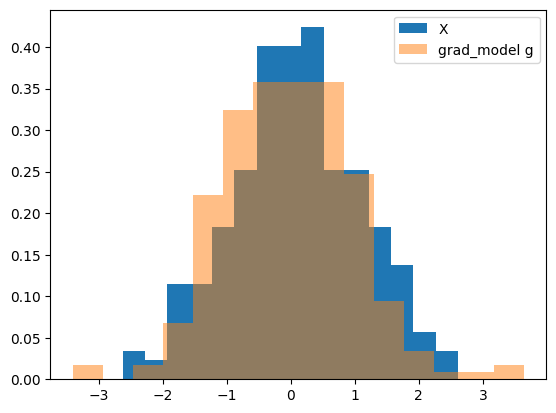

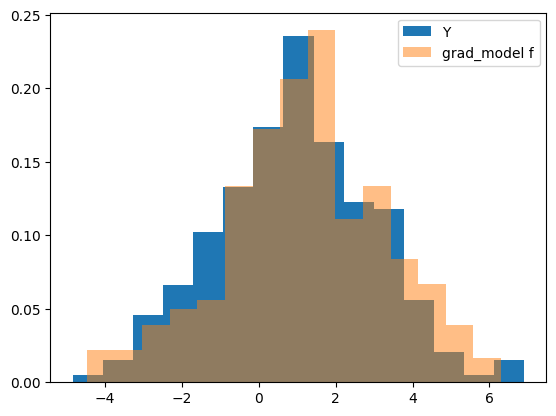

In [31]:
X = dataloader.dataset.X
Y = dataloader.dataset.Y
C = dataloader.dataset.C

#Calcul de la dérivée du PICNN
test = 50
x_i = X[test, :, :]
y_i = Y[test, :, :]
c_i = C[test, :, :]


y_i.requires_grad_(True)
x_i.requires_grad_(True)
c_i.requires_grad_(True)    

output_model_f = ICNNf(x_i, c_i)
grad_model_f = torch.autograd.grad(outputs=output_model_f, inputs=x_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]

output_model_g = ICNNg(y_i, c_i)
grad_model_g = torch.autograd.grad(outputs=output_model_g, inputs=y_i, grad_outputs=torch.ones_like(output_model), create_graph=True)[0]


plt.hist(X[test, :, 0],  bins=15, label = 'X', density = True)
plt.hist(grad_model_g[:, 0].detach().numpy(),  bins=15, label = 'grad_model g', density = True, alpha = 0.5)
plt.legend()
plt.show()

plt.hist(Y[test, :, 0],  bins=15, label = 'Y', density = True)
plt.hist(grad_model_f[:, 0].detach().numpy(),  bins=15, label = 'grad_model f', density = True, alpha = 0.5)
plt.legend()
plt.show()